In [6]:
import os, sys, tarfile

def extract(tar_url, extract_path='.'):
    print(tar_url)
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])
try:
    extract('CUB_200_2011.tgz')
    print('Done.')
except:
    pass

CUB_200_2011.tgz
Done.


In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import pandas as pd
import time

In [52]:
def inference(input_image):
    # print(input_image.filename)
    preprocess = transforms.Compose([
        transforms.Resize(448),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    return input_tensor
    # return input_image
    

In [53]:
index = pd.read_csv('./Dataset/images.txt',delimiter=' ', header=None).rename(columns={0:'id',1:'path'})

In [54]:
index = index.join(pd.read_csv('./CUB_200_2011/image_class_labels.txt',delimiter=' ', header=None).rename(columns={1:'class'}).set_index(0), on='id',how='left')

In [55]:
index['img'] = index.path.apply(lambda x: inference(Image.open("Dataset/" + x)))

In [56]:
mapping_function = dict(zip(list(index['class'].unique()), list(range(25))))

In [57]:
index['class'] = index['class'].map(mapping_function)

In [58]:
X = index['img'].to_list()
y = index['class'].to_list()

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2)

In [60]:
train_set = set(X_train)

In [61]:
import swifter

In [262]:
len(index)

1442

In [62]:
index['train'] = index['img'].swifter.apply(lambda x: x in train_set)

Pandas Apply:   0%|          | 0/1442 [00:00<?, ?it/s]

In [63]:
train_data = index[index['train']].reset_index(drop=True)

In [64]:
train_data.columns

Index(['id', 'path', 'class', 'img', 'train'], dtype='object')

In [65]:
class Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 3]
        label = self.data.iloc[idx, 2]
        return image, label

In [66]:
train_dataset = Dataset(train_data)

In [117]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

In [118]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [162]:
class Classifer(nn.Module):
    def __init__(self, original_model):
        super(Classifer, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-7])
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(768, 25)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.features(x)
        ft = self.pooling(x)
        x = self.fc(ft.squeeze(2).squeeze(2))
        x = self.softmax(x)
        return x, ft

inception = models.inception_v3(pretrained=True, aux_logits=False)
classifer = Classifer(inception).to(device)
# classifer = Classifer(inception)

In [163]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifer.parameters(), lr=0.1, momentum=0.9,weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [164]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    for epoch in range(num_epochs):
        
        model.train()  # Set model to training mode

        # Iterate over data.
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs,_ = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(loss.item())
        scheduler.step()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return model

In [165]:
classifer = train_model(classifer, train_dataloader, criterion, optimizer, scheduler)

3.2148611545562744
3.217118740081787
3.1983203887939453
3.2043392658233643
3.1797568798065186
3.0185630321502686
3.0220067501068115
3.078876495361328
3.038107395172119
3.08115816116333
3.0668210983276367
2.84797739982605
2.9457290172576904
2.8209073543548584
2.8253564834594727
2.8072385787963867
2.792241334915161
2.837726354598999
2.7430338859558105
2.909686326980591
2.8986213207244873
2.754636526107788
2.8091630935668945
2.7294631004333496
2.783522844314575
2.6350584030151367
2.6926965713500977
2.8097736835479736
2.565645217895508
2.7438242435455322
2.771313190460205
2.76473331451416
2.656177282333374
2.5840063095092773
2.634359836578369
2.6184709072113037
2.6262197494506836
2.5466597080230713
2.539764404296875
2.516880750656128
2.495474338531494
2.684995412826538
2.5673155784606934
2.743809700012207
2.6141462326049805
2.582096576690674
2.520287275314331
2.576885461807251
2.4847776889801025
2.5993130207061768
2.49831223487854
2.525960922241211
2.5314431190490723
2.643263578414917
2.62

In [166]:
test_data = index[index['train'] == False].reset_index(drop=True)

In [167]:
classifer =  classifer.to('cpu')

In [170]:
def result(x):
    t,_ = classifer(x.unsqueeze(0))
    return torch.argmax(t).item()

In [172]:
classifer.eval()
test_data['pred'] = test_data.img.apply(lambda x: result(x))

In [173]:
test_data.apply(lambda x: x['class'] == x['pred'], axis=1).sum() / len(test_data)

0.615916955017301

In [175]:
def feature(x):
    return classifer(x.unsqueeze(0))[1].squeeze().detach().numpy()

In [176]:
train_data['feature'] = train_data.img.apply(lambda x : feature(x))

In [181]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.spatial import distance
from sklearn.decomposition import PCA

In [253]:
pca = PCA(n_components=30)
train_data['pc'] = list(pca.fit_transform(np.array(train_data['feature'].to_list())))

In [254]:
train_data.columns

Index(['id', 'path', 'class', 'img', 'train', 'feature', 'pc'], dtype='object')

In [255]:
class_feature = train_data.groupby('class').apply(lambda x: np.array(x['pc'].to_list())).reset_index().rename(columns={0:'pc'})

In [256]:
class_feature

,class,pc
0,0,"[[-1.20359, -1.6335894, -1.7803915, -0.956747,..."
1,1,"[[-1.1778817, 1.0877463, -0.06584552, 1.152793..."
2,2,"[[1.3189378, -2.126412, 0.73290133, 3.4765391,..."
3,3,"[[-0.4320204, -0.95725673, -1.474642, -0.95403..."
4,4,"[[0.06828668, 1.0433329, -4.762152, -5.164641,..."
5,5,"[[-1.4196024, 2.822311, -1.7839302, -0.5402782..."
6,6,"[[-0.6410658, 4.871716, -5.090187, 2.1866539, ..."
7,7,"[[-5.9435287, 7.7912927, 1.8622111, 2.2666452,..."
8,8,"[[2.8148313, 1.840461, 0.15477069, 1.8765984, ..."
9,9,"[[2.1406567, -0.203476, -2.6124048, 2.5930817,..."


In [257]:
def KL_divergence(class_j, class_k):
    meanj = np.mean(class_j, axis=0)
    covj = np.cov(class_j, rowvar=0)
    meank = np.mean(class_k, axis=0)
    covk = np.cov(class_k, rowvar=0)
    return 0.5*(np.trace(np.matmul(np.linalg.pinv(covk), covj) - np.identity(covj.shape[0])) + np.log(np.linalg.det(covk) / np.linalg.det(covj)) + (meanj - meank).T @ np.linalg.pinv(covk) @ (meanj - meank))

In [258]:
def JS_divergence(class_j, class_k):
    class_jk = np.concatenate((class_j, class_k), axis=0)
    return 0.5 * (KL_divergence(class_j, class_jk) + KL_divergence(class_k, class_jk))

In [259]:
dist_matrix = np.zeros((25,25))
for i in range(25):
    for j in range(25):
        dist_matrix[i][j] = JS_divergence(class_feature.iloc[i,1],class_feature.iloc[j,1])

In [265]:
import seaborn as sns

<AxesSubplot:>

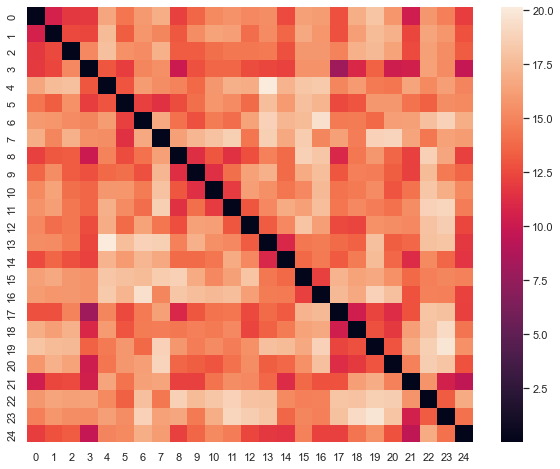

In [273]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.heatmap(dist_matrix)

In [263]:
np.dstack(np.unravel_index(np.argsort(dist_matrix.ravel()), (25, 25)))[0][25:55]

array([[17,  3],
       [ 3, 17],
       [24, 21],
       [21, 24],
       [ 3, 24],
       [24,  3],
       [ 3,  8],
       [ 8,  3],
       [20,  3],
       [ 3, 20],
       [ 0, 21],
       [21,  0],
       [18, 17],
       [17, 18],
       [ 3, 21],
       [21,  3],
       [21, 23],
       [23, 21],
       [ 0,  1],
       [ 1,  0],
       [14, 13],
       [13, 14],
       [ 8, 17],
       [17,  8],
       [18,  3],
       [ 3, 18],
       [14, 21],
       [21, 14],
       [20, 17],
       [17, 20]], dtype=int64)

In [215]:
mapping_function

{5: 0,
 6: 1,
 7: 2,
 77: 3,
 78: 4,
 79: 5,
 80: 6,
 81: 7,
 82: 8,
 139: 9,
 140: 10,
 149: 11,
 150: 12,
 59: 13,
 61: 14,
 63: 15,
 64: 16,
 151: 17,
 152: 18,
 156: 19,
 157: 20,
 141: 21,
 142: 22,
 143: 23,
 147: 24}

In [42]:
box = pd.read_csv('./CUB_200_2011/parts/part_locs.txt', delimiter=' ', header=None).rename(columns={0:'id',1:'part',2:'x',3:'y',4:'visible'})

In [43]:
box = box[box['visible'] == 1]

In [44]:
box = box[(box['part'] == 8) | (box['part'] == 12)]

In [45]:
data_id = index[index['class'] != 1]['id'].to_list()

In [46]:
box = box[box['id'].isin(data_id)]

In [47]:
box = box.join(index.set_index('id'), on='id', how='left')

In [48]:
import matplotlib.pyplot as plt

In [49]:
def mask(path, x, y):
    input_image = Image.open("Dataset/" + path)
    rows,cols,chls = np.array(input_image).shape
    mask = np.zeros((rows, cols),dtype=np.int8)
    mask[y-40: y+40, x-20:x+20] = 1
    mask_image = np.transpose(mask * np.transpose(np.array(input_image), (2, 0, 1)), (1, 2, 0))
    return inference(Image.fromarray(mask_image.astype('uint8'), 'RGB'))

In [50]:
box['img'] = box.apply(lambda x: mask(x['path'], int(x['x']), int(x['y'])), axis=1)

In [57]:
box['class'] = box['class'].map({0:0,2:1})

In [ ]:
train_data_2 = train_data[['img', 'class']]

In [59]:
train_data_2 = train_data_2[train_data_2['class'] != 1]

In [60]:
train_data_2['class'] = train_data_2['class'].map({0:0,2:1})

In [78]:
att_train_data = pd.concat([train_data_2[['img', 'class']],box[['img','class']].sample(45)])

In [79]:
att_train_data = att_train_data.reset_index(drop=True)

In [100]:
class Attention_Classifer(nn.Module):
    def __init__(self, original_model):
        super(Attention_Classifer, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-7])
        self.attention = nn.Conv2d(768, 1, (1,1))
        self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear(768, 2)
        
    def forward(self, x):
        x = self.features(x)
        q = self.attention(x)
        q = self.softmax(q.reshape(-1, 17*17))
        a = torch.matmul(x.reshape(-1, 768, 17*17), q.reshape(-1, 17*17, 1))
        x = self.fc(a.squeeze())
        return x

inception = models.inception_v3(pretrained=True, aux_logits=False)
local_classifier = Attention_Classifer(inception).to(device)


In [101]:
class Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        return image, label

In [102]:
att_train_dataset = Dataset(att_train_data)

In [103]:
att_train_dataloader = DataLoader(att_train_dataset, batch_size=8, shuffle=True)

In [104]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(local_classifier.parameters(), lr=0.1, momentum=0.9,weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [105]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    for epoch in range(num_epochs):
        
        model.train()  # Set model to training mode

        # Iterate over data.
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            print(loss.item())

            loss.backward()
            optimizer.step()
        scheduler.step()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return model

In [106]:
local_classifier = train_model(local_classifier, att_train_dataloader, criterion, optimizer, scheduler)

0.7090314626693726
1.0479533672332764
0.741875410079956
0.8840682506561279
0.7380552887916565
0.9219526052474976
1.9431511163711548
0.7768198251724243
2.106538772583008
1.2657525539398193
0.5806979537010193
1.0070370435714722
1.0123159885406494
1.2688586711883545
0.6536158919334412
0.7263967990875244
0.6304922103881836
0.8204920291900635
0.8905126452445984
0.7891912460327148
0.5496711730957031
0.6868773698806763
0.7651685476303101
0.5701394081115723
0.9339814186096191
0.563400149345398
0.6674501895904541
0.691209614276886
0.77388995885849
0.707817554473877
0.7106030583381653
0.6817921996116638
0.7749466300010681
0.7877354025840759
0.6456864476203918
0.6143025159835815
0.7593280076980591
0.74823397397995
0.8032786250114441
0.724934995174408
0.6825655698776245
0.6835566163063049
0.7002342343330383
0.7555577754974365
0.6331218481063843
0.5965258479118347
0.6576895713806152
0.5477197170257568
0.8438806533813477
0.7804771065711975
0.7158148884773254
0.6590218544006348
0.5939291715621948
0.7

In [89]:
local_classifier =  local_classifier.to('cpu')

In [90]:
def result(x):
    t = local_classifier(x.unsqueeze(0))[0]
    return torch.argmax(torch.nn.Softmax(dim=0)(t)).item()

In [91]:
att_test_data = test_data[test_data['class'] != 1]

In [93]:
local_classifier.eval()
att_test_data['att_pred'] = att_test_data.img.apply(lambda x: result(x))

C:\Users\Song_\AppData\Local\Temp/ipykernel_25852/1274288069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  att_test_data['att_pred'] = att_test_data.img.apply(lambda x: result(x))


In [273]:
att_test_data['class']

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
30    2
31    2
32    2
33    2
34    2
35    2
36    2
37    2
38    2
39    2
40    2
41    2
42    2
43    2
44    2
Name: class, dtype: int64